# Climate change project plan

The main goal of this project is to explore some open source planetary temperautre data in order to understand the planet's temperature trends of the past few centuries. The temperature dataset we use in this project originates from https://berkeleyearth.org/data/. The temperature data represents the global earth temperatures and the aquisition uncertainties for the earth Land only regions and both Land and Ocean regions. 

Project summary: 
The first part of this data exploration project is defined by an initial exploration of the dataset and is followed by a visualisual analysis of the earth temperature measurements as function of time. The visualiy observed trend in earth temperature is explored in details in the second part of the project where we aim to simulate the existing data first and secondly to forecast the evolution of this trend in the 21th century. 

Table of content: 

* 1. Initial data exploration:
    * Loading dataset
    * Exploring the dataset
    * Engineering new dataset attributes
    * Earth's temperature seasonality
    * Earth's temperature time evolution 
    
* 2. Compring Earth's temperature forecasting using statistics and machine learning:
    * Forecasting time series using ARIMA model:
        * Converting data into a time series object
        * Forecasting the monthly temperature time series using the SARIMA model
        * Forecasting the yearly temperature time series using the ARIMA model
            * Visualising forecasted yearly temperature trend in the 21th century 

## Import libraries and general details:

In [188]:
# Python ≥3.10 is required
import sys
assert sys.version_info >= (3,10)

# Common imports
import numpy as np
import pandas as pd
import os
import datetime
import pmdarima as pm # Auto-Arima package >- 2,0,0
import scipy.stats as st
from scipy.stats import linregress

# Make this notebook's output stable across runs
np.random.seed(42)

# Need to set the PROJ_LIB environment variable either before starting your notebook or in python with:
os.environ['PROJ_LIB'] = '''/Users/atsoc/miniconda3/envs/TensorVenv/share/proj'''

# To plot pretty figures
%matplotlib inline
from matplotlib import pyplot as plt, patches
import matplotlib.ticker as ticker
import seaborn as sns

# ## Reset the matplotlib style file to default
# mpl.rcParams.update(mpl.rcParamsDefault)
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 10, 6

# Library where to save the figures:
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "climate_change"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images" + '_' + PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok=True) # exist_ok avoid OSError error if directory exists already

def save_fig(figure_id, fig_extension="png", resolution=300):
    PATH_FIGURES = os.path.join(IMAGES_PATH, figure_id + "." + fig_extension)
    print("Saving figure:\"", figure_id, "\"")
    plt.savefig(PATH_FIGURES, format=fig_extension, dpi=resolution)

## Initial data exploration:

Reading the data from a csv file into a Pandas DataFrame

In [2]:
data_global_temperatures = pd.read_csv('Data/GlobalTemperatures.csv')

List of columns available in the dataset. Each Temperature measurement column has a dedicated temperature unctainty column. 

In [3]:
data_raw_columns = data_global_temperatures.columns.to_list()
data_raw_columns

['dt',
 'LandAverageTemperature',
 'LandAverageTemperatureUncertainty',
 'LandMaxTemperature',
 'LandMaxTemperatureUncertainty',
 'LandMinTemperature',
 'LandMinTemperatureUncertainty',
 'LandAndOceanAverageTemperature',
 'LandAndOceanAverageTemperatureUncertainty']

As we can see below some data is missing for most of the columns. We would like to estimate the number of missing values in each of the columns.

In [4]:
data_global_temperatures.head(5)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_global_temperatures.isna().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

It looks like most of the temperature measurements columns are missing the same number of measurements (1200), we can easily check if these measurements correspond to the same time periods.

In [6]:
data_global_temperatures[['dt', 'LandMaxTemperature']][data_global_temperatures.LandMaxTemperature.isna()]

,dt,LandMaxTemperature
0,1750-01-01,NaN
1,1750-02-01,NaN
2,1750-03-01,NaN
3,1750-04-01,NaN
4,1750-05-01,NaN
...,...,...
1195,1849-08-01,NaN
1196,1849-09-01,NaN
1197,1849-10-01,NaN
1198,1849-11-01,NaN


Saving figure:" Missing values in the dataset "


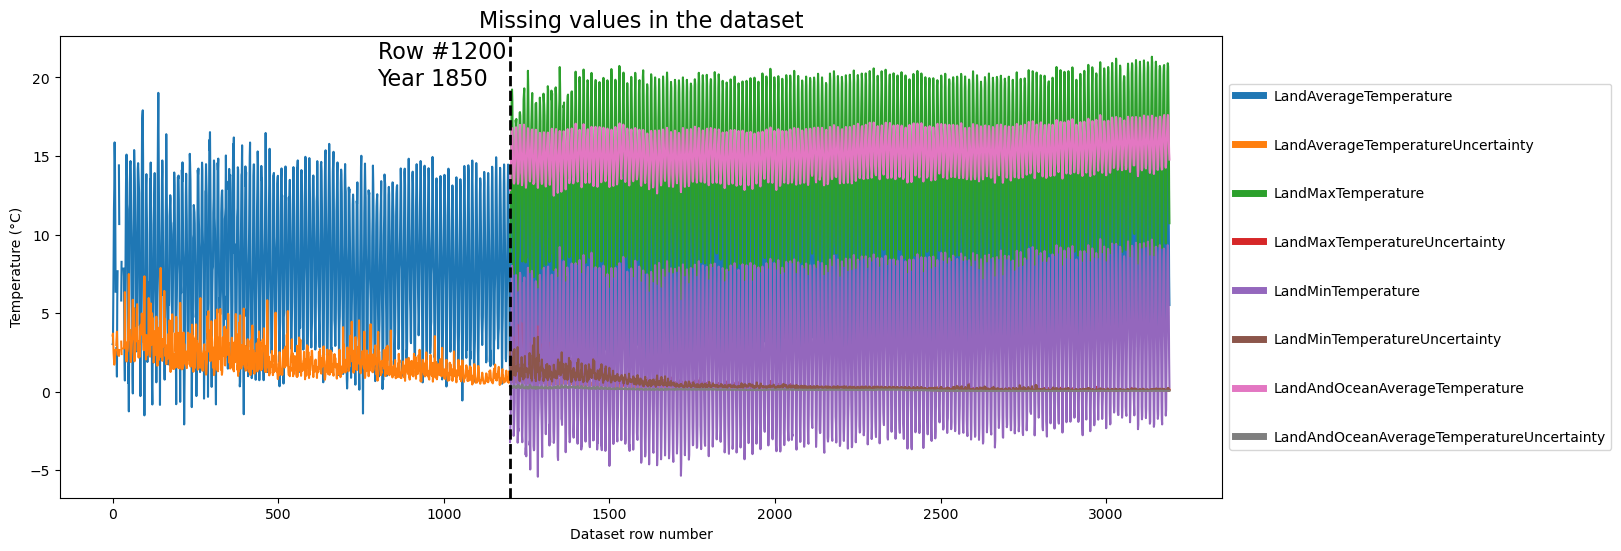

In [251]:
plt.figure(figsize=(15,6))
for column in data_raw_columns[1:]:
    plt.plot(data_global_temperatures[str(column)], label=str(column))
# plt.legend(loc='best')
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),labelspacing=2.5)

# change the line width for the legend
for line in legend.get_lines():
    line.set_linewidth(5)

plt.xlabel('Dataset row number')
plt.ylabel('Temperature (°C)')
plt.axvline(1200, color='black', ls='--', linewidth=2)
plt.title('Missing values in the dataset', fontsize=16)
plt.text(x=800, y = 19.5, s = 'Row #1200 \nYear 1850',fontsize=16)
save_fig('Missing values in the dataset')
plt.show()

We can clearly see on the graph above that most of the data is missing from 1750 to 1849, and a complete data is available from 1850 to 2015. This could be related to the less common temperature measurement in the 18th and first half of the 19th centurries. In the following data exploration analisys we will consider 1850 as the starting point of reliable temperature measurements.

#### Engineering new dataset attributes: Ocean average temperature
We can estimate the OceanAverageTemperature by substracting "LandAverageTemperature" from "LandAndOceanAverageTemperature"

In [8]:
data_global_temperatures["OceanAverageTemperature"] = data_global_temperatures["LandAndOceanAverageTemperature"] - data_global_temperatures["LandAverageTemperature"]
data_global_temperatures["OceanAverageTemperatureUncertainty"] = data_global_temperatures["LandAndOceanAverageTemperatureUncertainty"] + data_global_temperatures["LandAverageTemperatureUncertainty"]

#### Earth's temperature seasonality
We convert the dataframe dataset into a time series as it's easier to work with x-axis in terms of time. So we set the index to be the 'dt' column of the new timeseires dataframe

In [9]:
ts = data_global_temperatures[['dt', 'LandAndOceanAverageTemperature']]

In [10]:
data_seasonality = pd.DataFrame(ts['LandAndOceanAverageTemperature'].values, columns = ['LandAndOceanAverageTemperature'], index = pd.to_datetime(ts['dt']))
data_seasonality.index.freq = 'MS'
data_seasonality['month'] = data_seasonality.index.month
data_seasonality['year'] = data_seasonality.index.year

Saving figure:" Yearly temperature seasonality "


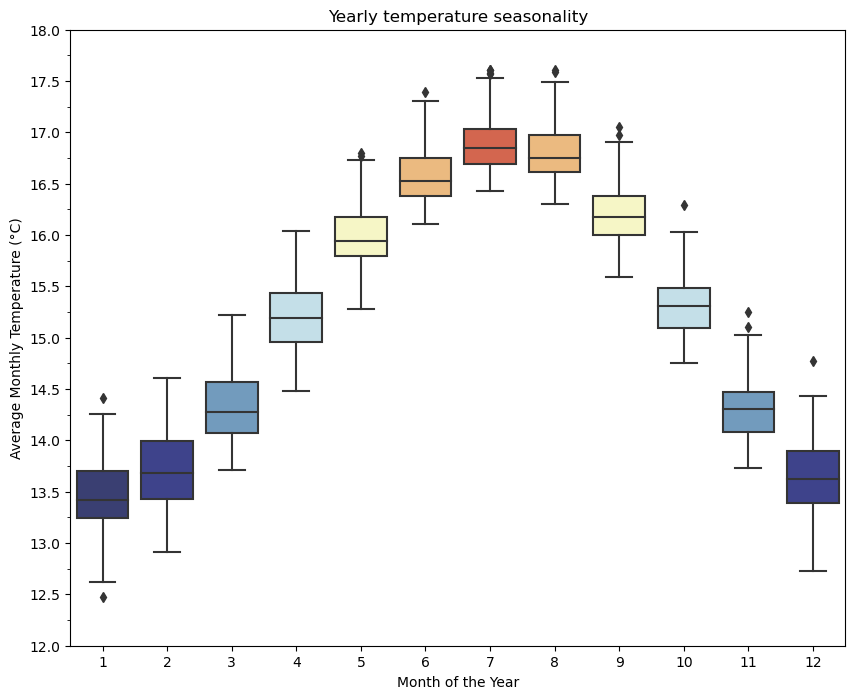

In [11]:
palette = ["#31387B", "#313898", "#669CC9", "#BEE2EE", "#FEFEBE", 
           "#FDBB6E", "#E95739", "#FDBB6E", "#FEFEBE", "#BEE2EE", 
           "#669CC9", "#313898"]
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data_seasonality, x='month', y='LandAndOceanAverageTemperature', palette=sns.color_palette(palette, 12))
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Average Monthly Temperature (°C)')
ax.set_title('Yearly temperature seasonality')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
ax.set_ylim([12,18])

save_fig("Yearly temperature seasonality")
plt.show()

There is a clear seasonality trend in the data, we see for instance that summer months 6 to 8 the temperature is at it's highest, whereas in the winter months the temperature is considerably falling down. The range of tmeperatures between summer and winter is about 4 degrees celcius.

#### Earth's temperature time evolution 
Add y-axis minor tickes and also implement a color palette to the box plots. Color should be proportional to the temperature value. 

In [12]:
def yearly_temperature_calculation(dataset): 
    dataset_columns =  dataset.columns.to_list()
    yearly_columns = ['Year'] + ['Yearly' + column for column in dataset_columns[1:]]

    yearly_dataset = pd.DataFrame(columns=yearly_columns)

    for year in range(1750, 2015 + 1, 1):
            yearly_dataset.loc[year,['Year']] = year

    for i in range(1,len(yearly_columns),1):
        for year in range(1750, 2015 + 1, 1):
            yearly_dataset.loc[year,[yearly_columns[i]]] = dataset[dataset['dt'].str.contains(str(year))][dataset_columns[i]].mean()

    yearly_dataset = yearly_dataset.astype(float)
    yearly_dataset['Year'] = yearly_dataset['Year'].astype(int)
    return yearly_dataset

data_global_yearly_temperatures = yearly_temperature_calculation(data_global_temperatures)

In [13]:
data_global_yearly_temperatures

,Year,YearlyLandAverageTemperature,YearlyLandAverageTemperatureUncertainty,YearlyLandMaxTemperature,YearlyLandMaxTemperatureUncertainty,YearlyLandMinTemperature,YearlyLandMinTemperatureUncertainty,YearlyLandAndOceanAverageTemperature,YearlyLandAndOceanAverageTemperatureUncertainty,YearlyOceanAverageTemperature,YearlyOceanAverageTemperatureUncertainty
1750,1750,8.719364,2.637818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1751,1751,7.976143,2.781143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1752,5.779833,2.977000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1753,1753,8.388083,3.176000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1754,1754,8.469333,3.494250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2011,2011,9.516000,0.082000,15.284833,0.114333,3.827667,0.136583,15.769500,0.059000,6.253500,0.141000
2012,2012,9.507333,0.083417,15.332833,0.107333,3.756167,0.145333,15.802333,0.061500,6.295000,0.144917
2013,2013,9.606500,0.097667,15.373833,0.115500,3.911333,0.149833,15.854417,0.064667,6.247917,0.162333
2014,2014,9.570667,0.090167,15.313583,0.111667,3.877750,0.139000,15.913000,0.063167,6.342333,0.153333


Saving figure:" Earth yearly temperature trends "


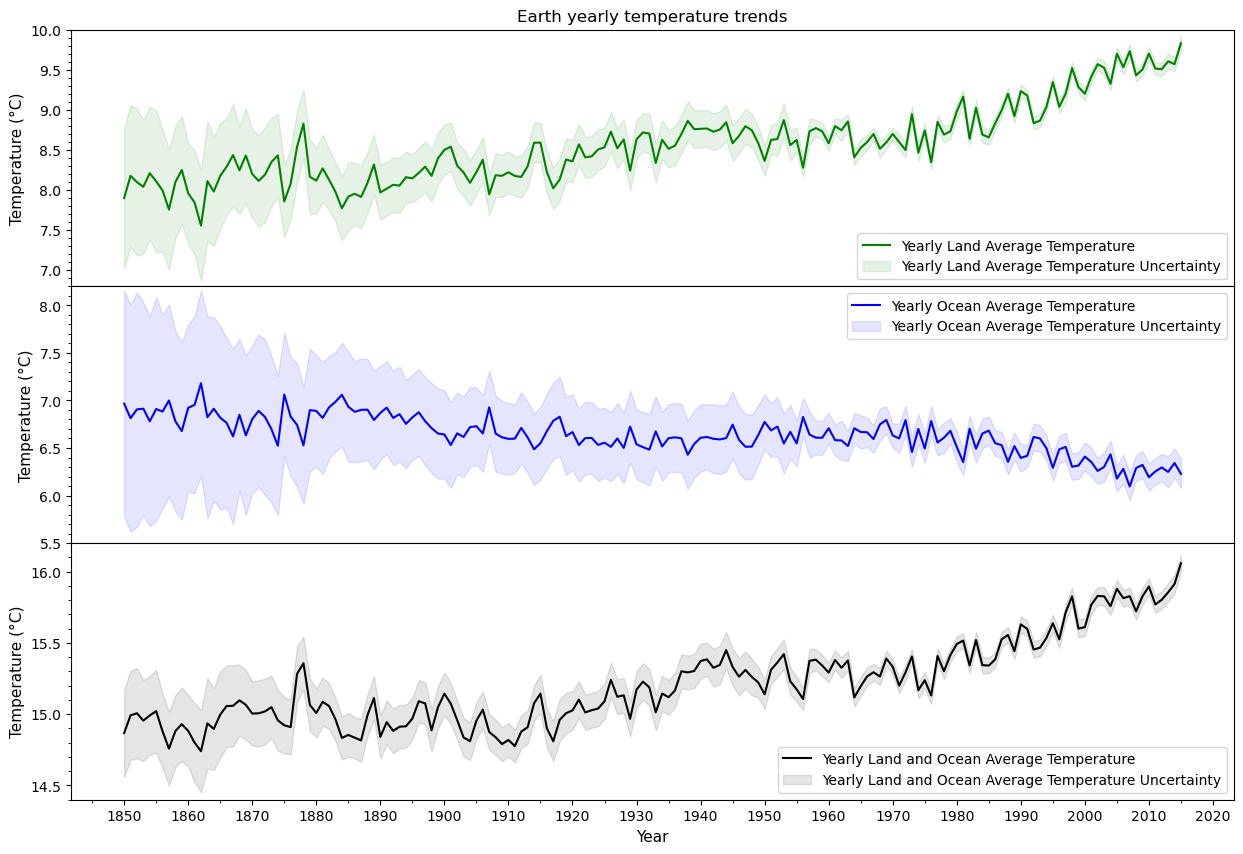

In [14]:
beginning_year, end_year = 1850, 2015

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15, 10))

fig.subplots_adjust(hspace=0)

ax1.plot(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year],data_global_yearly_temperatures['YearlyLandAverageTemperature'].loc[beginning_year:end_year],'g', label='Yearly Land Average Temperature')
ax1.fill_between(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyLandAverageTemperature'].loc[beginning_year:end_year] - data_global_yearly_temperatures['YearlyLandAverageTemperatureUncertainty'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyLandAverageTemperature'].loc[beginning_year:end_year] + data_global_yearly_temperatures['YearlyLandAverageTemperatureUncertainty'].loc[beginning_year:end_year], alpha=0.1, edgecolor='g', facecolor='g',label='Yearly Land Average Temperature Uncertainty')
ax1.set_ylim([6.8,10])
ax1.legend(loc='lower right')
ax1.set_ylabel('Temperature (°C)', fontsize=11)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax1.set_title('Earth yearly temperature trends',fontsize=12)

ax2.plot(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year],data_global_yearly_temperatures['YearlyOceanAverageTemperature'].loc[beginning_year:end_year],'b',label='Yearly Ocean Average Temperature')
ax2.fill_between(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyOceanAverageTemperature'].loc[beginning_year:end_year] - data_global_yearly_temperatures['YearlyOceanAverageTemperatureUncertainty'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyOceanAverageTemperature'].loc[beginning_year:end_year] + data_global_yearly_temperatures['YearlyOceanAverageTemperatureUncertainty'].loc[beginning_year:end_year], alpha=0.1, edgecolor='b', facecolor='b', label='Yearly Ocean Average Temperature Uncertainty')
ax2.set_ylim([5.5,8.2])
ax2.legend(loc='best')
ax2.set_ylabel('Temperature (°C)', fontsize=11)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax3.plot(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year],data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[beginning_year:end_year],'k',label='Yearly Land and Ocean Average Temperature')
ax3.fill_between(data_global_yearly_temperatures['Year'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[beginning_year:end_year] - data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperatureUncertainty'].loc[beginning_year:end_year], data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[beginning_year:end_year] + data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperatureUncertainty'].loc[beginning_year:end_year], alpha=0.1, edgecolor='k', facecolor='k',label='Yearly Land and Ocean Average Temperature Uncertainty')
ax3.set_ylim([14.4,16.2])
ax3.legend(loc='lower right')
ax3.set_xlabel('Year', fontsize=11)
ax3.set_ylabel('Temperature (°C)', fontsize=11)

ax3.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax3.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
save_fig("Earth yearly temperature trends")
plt.show()

From the above figure it's clear that the earth's tempreature has a positive increasing trend. This trend is especially pronounced in the 20th century. Let's visualize the temperature evolution in comparison yo the 1951-1980 region temperautres. This will enable us to visualy see the temperature change in the past 200 years.

In [89]:
global_Yearly_temperature_1951_1980_avg = data_global_yearly_temperatures.loc[1951:1980,['YearlyLandAndOceanAverageTemperature']].mean()[0]
print('The average yearly global land and ocean temperature between 1951-1980 is ',round(global_Yearly_temperature_1951_1980_avg,2),'°C', sep='')

The average yearly global land and ocean temperature between 1951-1980 is 15.3°C


Saving figure:" Global average temperature "


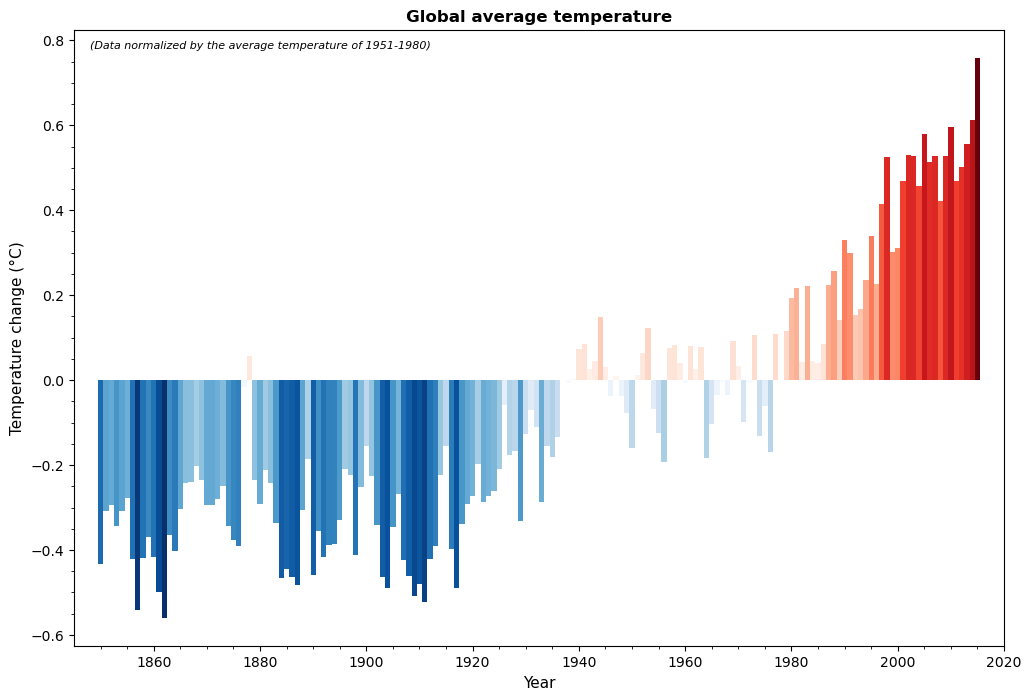

In [252]:
pos_cmap = plt.get_cmap("Reds")
neg_cmap = plt.get_cmap("Blues_r")

x = data_global_yearly_temperatures['Year'].loc[1850:]
y = data_global_yearly_temperatures['YearlyLandAndOceanAverageTemperature'].loc[1850:] -global_Yearly_temperature_1951_1980_avg

positive_mask = y > 0
negative_mask = y <= 0

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.figure(figsize=(12, 8))
plt.tight_layout()
plt.bar(x[positive_mask], y[positive_mask], width=1, color=pos_cmap(rescale(y[positive_mask])), linewidth=0.01)
plt.bar(x[negative_mask], y[negative_mask], width=1, color=neg_cmap(rescale(y[negative_mask])), linewidth=0.01)
plt.xlabel('Year', fontsize = 11)
plt.xlim([1845,2020])
plt.ylabel('Temperature change (°C)', fontsize = 11)
plt.title('Global average temperature', fontsize=12, fontweight="bold")
plt.text(x=1848, y = 0.78, s = '(Data normalized by the average temperature of 1951-1980)',fontsize=8, style='italic')
plt.minorticks_on()
save_fig("Global average temperature")
plt.show()

In [90]:
land_Yearly_temperature_1951_1980_avg = data_global_yearly_temperatures.loc[1951:1980,['YearlyLandAverageTemperature']].mean()[0]
print('The average yearly land temperature between 1951-1980 is ',round(land_Yearly_temperature_1951_1980_avg,2),'°C', sep='')

The average yearly land temperature between 1951-1980 is 8.66°C


Saving figure:" Land average temperature "


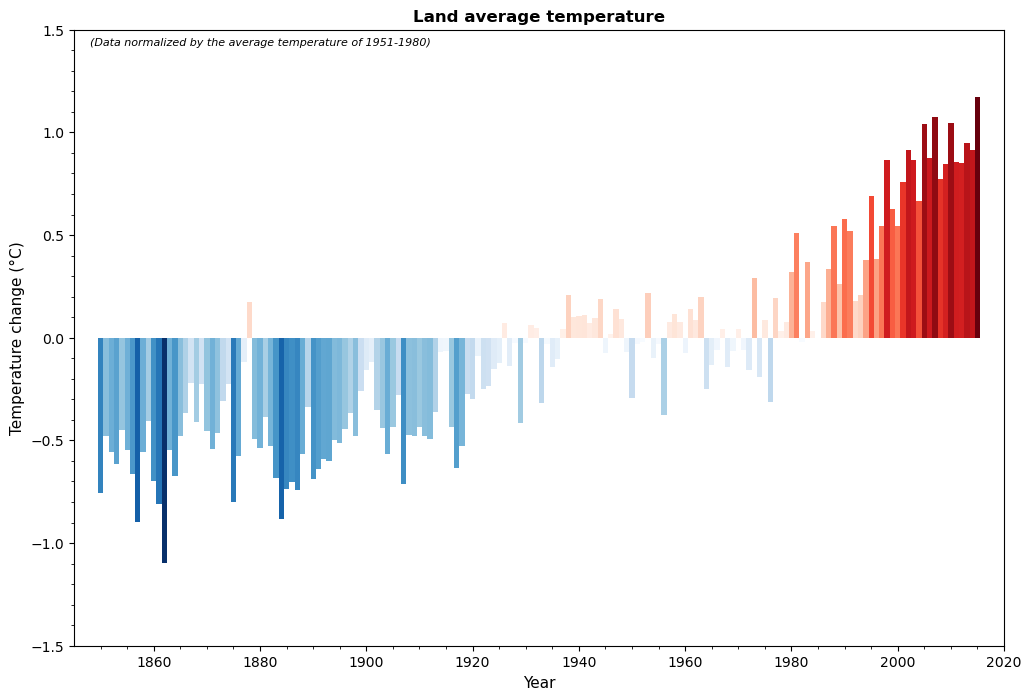

In [253]:
land_Yearly_temperature_1951_1980_avg = data_global_yearly_temperatures.loc[1951:1980,['YearlyLandAverageTemperature']].mean()[0]

pos_cmap = plt.get_cmap("Reds")
neg_cmap = plt.get_cmap("Blues_r")

x = data_global_yearly_temperatures['Year'].loc[1850:]
y = data_global_yearly_temperatures['YearlyLandAverageTemperature'].loc[1850:]-land_Yearly_temperature_1951_1980_avg

positive_mask = y > 0
negative_mask = y <= 0

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.figure(figsize=(12, 8))
plt.tight_layout()
plt.bar(x[positive_mask], y[positive_mask], width=1, color=pos_cmap(rescale(y[positive_mask])), linewidth=0.01)
plt.bar(x[negative_mask], y[negative_mask], width=1, color=neg_cmap(rescale(y[negative_mask])), linewidth=0.01)
plt.xlabel('Year', fontsize = 11)
plt.ylabel('Temperature change (°C)', fontsize = 11)
plt.xlim([1845,2020])
plt.ylim([-1.5,1.5])
plt.title('Land average temperature', fontsize=12, fontweight="bold")
plt.text(x=1848, y = 1.425, s = '(Data normalized by the average temperature of 1951-1980)',fontsize=8, style='italic')
plt.minorticks_on()
save_fig("Land average temperature")
plt.show()

## Earth's temperature forecasting using statistics ARIMA/SARIMA Models:
The ARIMA (AutoRegressive Integrated Moving Average) model is a class of statistical models for analyzing and forecasting time series data. 
* AR: AutoEegression - A model that uses the dependent relationship between an observation and some number of lagged observations.
    * p: The number of lag observations included in the model, also called the lag order.
* I: Integrated - The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
    * d: The number of times that the raw observations are differenced, also called the degree of differencing.
* MA: Moving Average - A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
    * q: The size of the moving average window, also called the order of moving average.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

### Converting data to time series

In [19]:
starting_dataset_date = 1850
final_dataset_date = 2015
index_starting_dataset_date = data_global_temperatures['dt'].str.contains(str(starting_dataset_date)).idxmax()
index_final_dataset_date = data_global_temperatures.dt.size

In [20]:
ts = data_global_temperatures[['dt', 'LandAndOceanAverageTemperature']]

In [21]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dt                              3192 non-null   object 
 1   LandAndOceanAverageTemperature  1992 non-null   float64
dtypes: float64(1), object(1)
memory usage: 50.0+ KB


In [22]:
data_temperature_ts = pd.Series(ts['LandAndOceanAverageTemperature'][index_starting_dataset_date:index_final_dataset_date].values, index = pd.to_datetime(ts['dt'][index_starting_dataset_date:index_final_dataset_date]))

In [23]:
data_temperature_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1992 entries, 1850-01-01 to 2015-12-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
1992 non-null   float64
dtypes: float64(1)
memory usage: 31.1 KB


We perform rolling mean and standard deviation to the monthly time series data:

From the above graphs, we see that rolling mean itself has a trend component even though rolling standard deviation is constant with time.

For a Time series to be stationary, its ADCF test should have:

p-value to be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

#### Forecasting seasonal time series: Auto-SARIMA Model
As we've previously seen our temeprature data has a pronounced seasonality of 12-month cycles. In this case, to forecast the seasonal global earth's temperature time series we need to perform a seasonal ARIMA model also called SARIMA. 

SARIMA models allow for differencing data by seasonal frequency, yet also by non-seasonal differencing. Determining the best set of parameters for the SARIMA model can be done through a grid-search type exploration using the pmdarima framework. The function pmdarima.auto_arima takes as inputs the time series data, the model evaluation test (ADF), and seasonality parameters (12-months).

In [44]:
SARIMA_model = pm.auto_arima(data_temperature_ts,
    start_p=1, start_q=1,
    test='adf',
    max_p=4, max_q=4, 
    m=12, #12 is the frequncy of the cycle
    start_P=0, 
    seasonal=True, #set to seasonal
    d=None, 
    D=1, #order of the seasonal differencing
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True, )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-837.953, Time=0.24 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-2204.786, Time=2.67 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-2284.318, Time=4.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-837.257, Time=0.18 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-1366.734, Time=0.29 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-2286.324, Time=5.26 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-1850.309, Time=2.07 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-2285.096, Time=18.13 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-2284.833, Time=20.54 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-2286.120, Time=15.48 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-2019.790, Time=6.39 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=-2283.633, Time=18.87 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-1626.524, Time=2.67 sec
 ARIMA(1,

In [39]:
# # We can display the model analysis dashboard to examine the performance of the selected model:
# SARIMA_model.plot_diagnostics(figsize=(15,12))
# plt.show()

In [254]:
def model_forecast_plot(model, dataset, forecast_periods, saved_figure_label):
    # Forecasting model for a given number of years
    fitted, confint = model.predict(n_periods = forecast_periods, return_conf_int = True, alpha=0.05)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(dataset, color='#1f76b4', label='Historical earth global temperature')
    plt.plot(fitted.index, fitted, color='darkgreen', label='Forecasted earth global temperature')
    plt.fill_between(fitted.index, 
                    confint[:, 0], 
                    confint[:, 1], 
                    color='k', alpha=.15,
                    label='Confidence interval of forecast: 95%')
    plt.title("Earth global temperature: historical data and forecast")
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Year')
    plt.minorticks_on()
    legend = plt.legend(loc='upper left')
    for line in legend.get_lines():
        line.set_linewidth(5)
    save_fig(saved_figure_label)
    plt.show()

In [60]:
data_temperature_ts

dt
1850-01-01    12.833
1850-02-01    13.588
1850-03-01    14.043
1850-04-01    14.667
1850-05-01    15.507
               ...  
2015-08-01    17.589
2015-09-01    17.049
2015-10-01    16.290
2015-11-01    15.252
2015-12-01    14.774
Length: 1992, dtype: float64

Saving figure:" SARIMA Model "


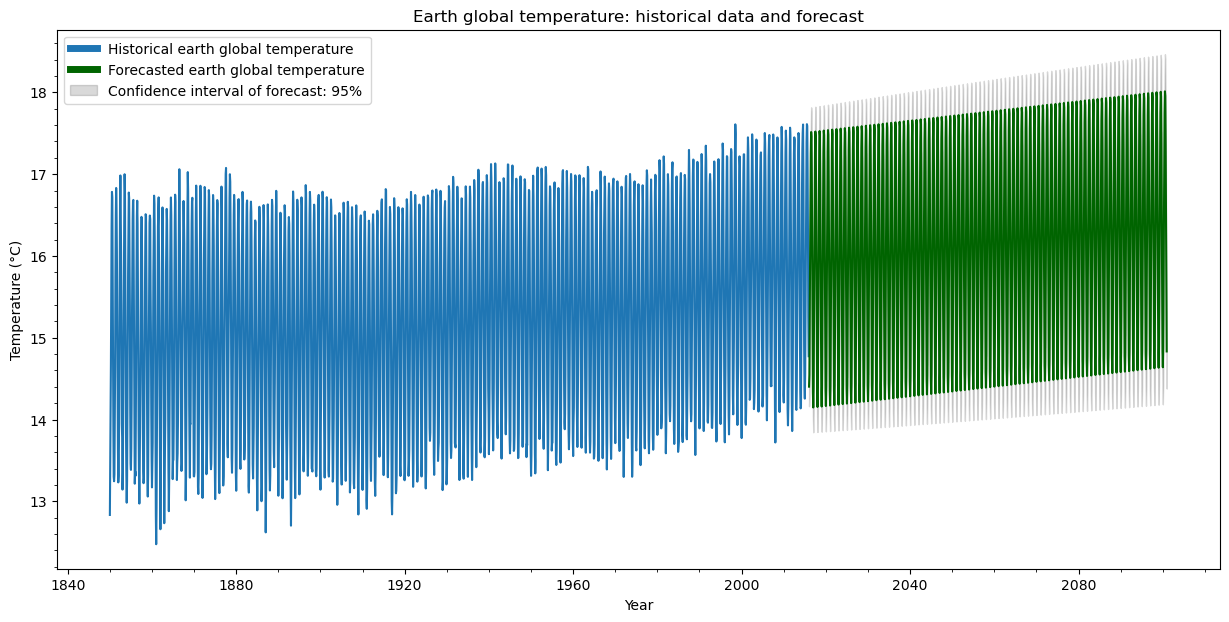

In [255]:
forecast_years = 85
model_forecast_plot(SARIMA_model,data_temperature_ts, forecast_years * 12, 'SARIMA Model' ) # Convert forecast_years in months

#### Forecasting non-seasonal time series: Auto-ARIMA Model
In this section we convert the monthly temperature time series into yearly data and perform a non-seasonal ARIMA model to forecast the new time series.

In [71]:
data_yearly_temperature_ts = pd.Series(data_global_yearly_temperatures.loc[1850:,'YearlyLandAndOceanAverageTemperature'].values, index = pd.to_datetime(data_global_yearly_temperatures.loc[1850:,'Year'], format='%Y'))
data_yearly_temperature_ts.info()
data_yearly_temperature_ts.index.freq = 'AS-JAN'

<class 'pandas.core.series.Series'>
DatetimeIndex: 166 entries, 1850-01-01 to 2015-01-01
Series name: None
Non-Null Count  Dtype  
--------------  -----  
166 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


In [73]:
ARIMA_model = pm.auto_arima(data_yearly_temperature_ts,
    start_p=1, start_q=1,
    test='adf',
    max_p=6, max_q=6, 
    seasonal=False, #set to seasonal
    d=None, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-279.409, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-252.541, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-256.118, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-267.815, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-253.846, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-265.211, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-280.386, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-281.854, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-280.978, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-285.790, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-280.999, Time=0.11 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-283.679, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-282.634, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-279.828, Time=0.10 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

Saving figure:" ARIMA Model "


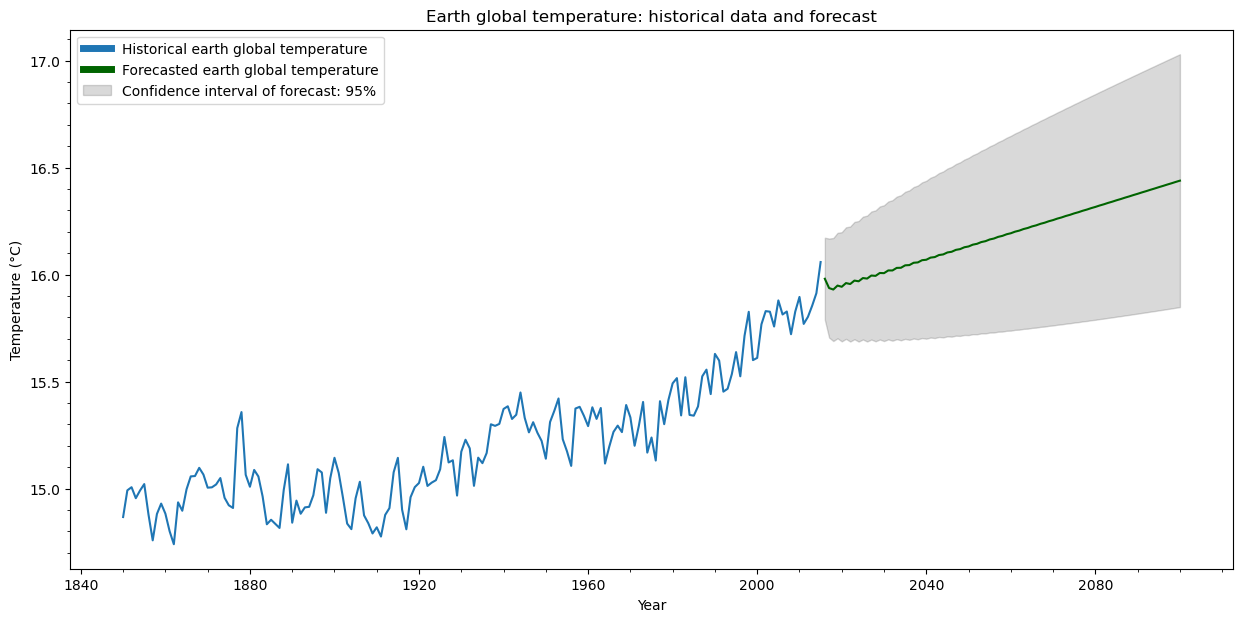

In [256]:
model_forecast_plot(ARIMA_model, data_yearly_temperature_ts, 85, 'ARIMA Model' )

We see that the ARIMA model forecast (in green) is characterized by a positive increasing trend with time. The temperature forecast predicts based on the historical data of 1850-2015 that earth temperature will continue growing. The light gray area around the greed forecast corresponds to the 95% confidence interval of the forecasl, it indicates that in all estimates the temperature evolution will be positively increasing in the 21th century.

In [75]:
fitted_yearly_arima = ARIMA_model.predict(n_periods = 85, return_conf_int = False, alpha=0.05)

In [79]:
data_yearly_temperature_ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 166 entries, 1850-01-01 to 2015-01-01
Freq: AS-JAN
Series name: None
Non-Null Count  Dtype  
--------------  -----  
166 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


In [78]:
fitted_yearly_arima.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 85 entries, 2016-01-01 to 2100-01-01
Freq: AS-JAN
Series name: None
Non-Null Count  Dtype  
--------------  -----  
85 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [80]:
data_21century_temperature_ts = pd.concat([data_yearly_temperature_ts,fitted_yearly_arima], axis=0)

In [108]:
data_21century_temperature_1951_1980_avg = data_21century_temperature_ts['1951-01-01':'1980-01-01'].mean()

In [ ]:
data_seasonality = pd.DataFrame(ts['LandAndOceanAverageTemperature'].values, columns = ['LandAndOceanAverageTemperature'], index = pd.to_datetime(ts['dt']))

In [121]:
data_21century_temperature = pd.DataFrame(data_21century_temperature_ts.values, columns = ['21CenturyLandAndOceanAverageTemperature'], index = np.arange(1850, 2101, 1) )

In [122]:
data_21century_temperature

,21CenturyLandAndOceanAverageTemperature
1850,14.867167
1851,14.991833
1852,15.006500
1853,14.955167
1854,14.991000
...,...
2096,16.414228
2097,16.420544
2098,16.426492
2099,16.432788


In [126]:
data_global_yearly_temperatures

,Year,YearlyLandAverageTemperature,YearlyLandAverageTemperatureUncertainty,YearlyLandMaxTemperature,YearlyLandMaxTemperatureUncertainty,YearlyLandMinTemperature,YearlyLandMinTemperatureUncertainty,YearlyLandAndOceanAverageTemperature,YearlyLandAndOceanAverageTemperatureUncertainty,YearlyOceanAverageTemperature,YearlyOceanAverageTemperatureUncertainty
1750,1750,8.719364,2.637818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1751,1751,7.976143,2.781143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1752,5.779833,2.977000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1753,1753,8.388083,3.176000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1754,1754,8.469333,3.494250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2011,2011,9.516000,0.082000,15.284833,0.114333,3.827667,0.136583,15.769500,0.059000,6.253500,0.141000
2012,2012,9.507333,0.083417,15.332833,0.107333,3.756167,0.145333,15.802333,0.061500,6.295000,0.144917
2013,2013,9.606500,0.097667,15.373833,0.115500,3.911333,0.149833,15.854417,0.064667,6.247917,0.162333
2014,2014,9.570667,0.090167,15.313583,0.111667,3.877750,0.139000,15.913000,0.063167,6.342333,0.153333


In [127]:
data_21century_temperature.index

Int64Index([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859,
            ...
            2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100],
           dtype='int64', length=251)

In [132]:
data_21century_temperature['21CenturyLandAndOceanAverageTemperature']

1850    14.867167
1851    14.991833
1852    15.006500
1853    14.955167
1854    14.991000
          ...    
2096    16.414228
2097    16.420544
2098    16.426492
2099    16.432788
2100    16.438754
Name: 21CenturyLandAndOceanAverageTemperature, Length: 251, dtype: float64

In [171]:
data_21century_temperature['21CenturyLandAndOceanAverageTemperature'] - data_21century_temperature_1951_1980_avg

1850   -0.432381
1851   -0.307714
1852   -0.293047
1853   -0.344381
1854   -0.308547
          ...   
2096    1.114681
2097    1.120996
2098    1.126945
2099    1.133241
2100    1.139207
Name: 21CenturyLandAndOceanAverageTemperature, Length: 251, dtype: float64

Saving figure:" 21 centuty average temperature "


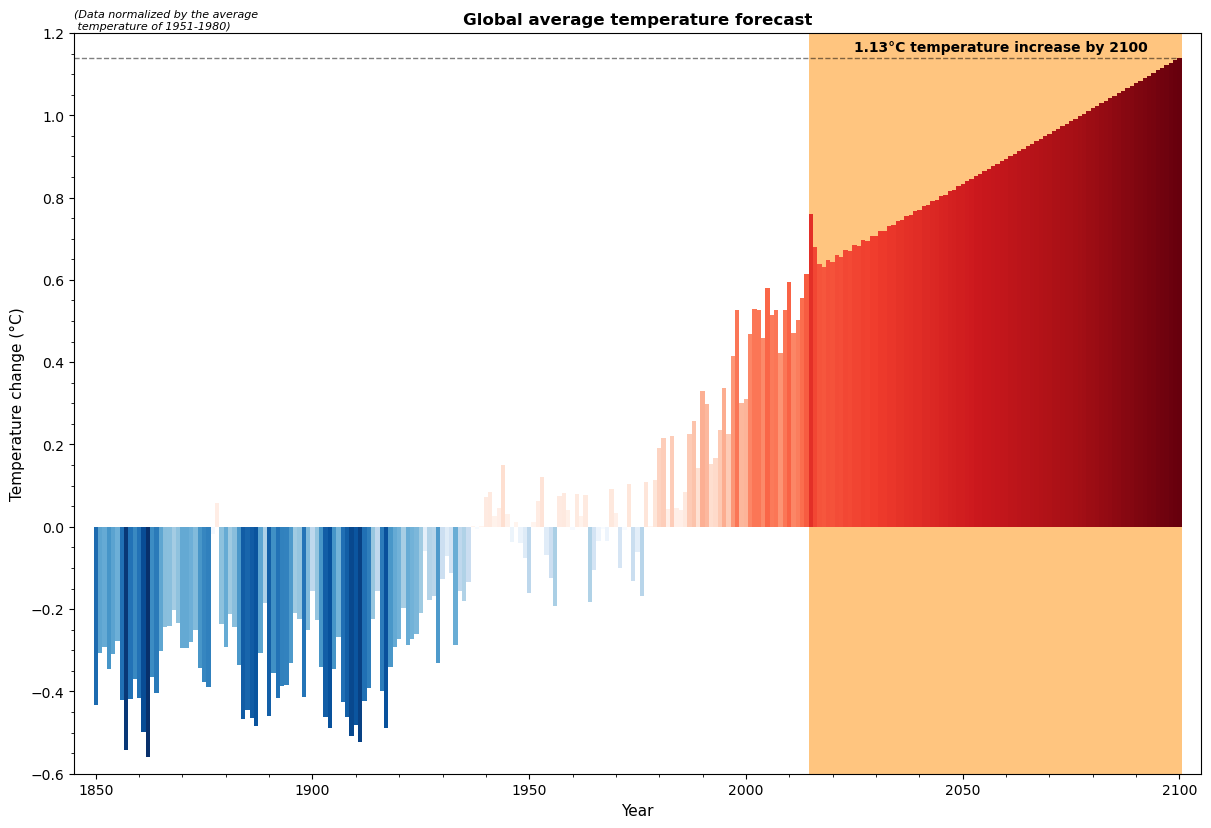

In [257]:
data_21century_temperature_1951_1980_avg = data_21century_temperature.loc[1951:1980, ['21CenturyLandAndOceanAverageTemperature']].mean()[0]

pos_cmap = plt.get_cmap("Reds")
neg_cmap = plt.get_cmap("Blues_r")

x = data_21century_temperature.index
y = data_21century_temperature['21CenturyLandAndOceanAverageTemperature'] - data_21century_temperature_1951_1980_avg

positive_mask = y > 0
negative_mask = y <= 0

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

figure, ax = plt.subplots(1, figsize=(12,8))

plt.tight_layout()
ax.bar(x[positive_mask], y[positive_mask], width=1, color=pos_cmap(rescale(y[positive_mask])), linewidth=0.01, zorder = 3)
ax.bar(x[negative_mask], y[negative_mask], width=1, color=neg_cmap(rescale(y[negative_mask])), linewidth=0.01, zorder = 4)
ax.set_xlabel('Year', fontsize = 11)
ax.set_ylabel('Temperature change (°C)', fontsize = 11)
ax.set_ylim([-0.6,1.2])
ax.set_xlim([1845,2105])
ax.set_title('Global average temperature forecast', fontsize=12, fontweight="bold")
ax.text(x=1845, y = 1.21, s = '(Data normalized by the average \n temperature of 1951-1980)',fontsize=8, style='italic')
# ax.axvline(2015, 0, 0.5,color='black', alpha=0.5 ,ls='--', linewidth=1, zorder = 1)
# ax.text(x=2016, y = -0.05, s = 'Forecast (2015 - 2100)',fontsize=10)
ax.axhline(1.14, 0, 0.98, color='black', alpha=0.5 ,ls='--', linewidth=1, zorder = 2)
ax.text(x=2025, y = 1.155, s = '1.13°C temperature increase by 2100',fontsize=10, weight='bold')
ax.minorticks_on()
rectangle = patches.Rectangle((2014.5, -0.6), 86, 1.8, edgecolor=None,
facecolor="darkorange", alpha =0.5, linewidth=2)
ax.add_patch(rectangle)
save_fig("21 centuty average temperature")
plt.show()

The ARIMA model forecast of the yearly temperature time series indicates that based on the historical data the earth temperature will continue increasing in the 21th century. This temperature increase trend is a naive approximation of the historically acquired data and doesn't consider any physical phenomeas or human interferance into earth climate. 
This data exploration and simulation of the future earth temperature are a case study for data analysis and statistical treatment of time series using existing python packages and frameworks.  